<a href="https://colab.research.google.com/github/Mariosenpai/Classificacao_Glaucoma/blob/main/Classificacao_glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Atividade de Visão Computacional para revisar passos básicos da aplicação

Instruções


1.   Escolha uma das bases de dados exemplificadas
2.   Implemente um dos algoritmos de extração de características sugeridos. Preste atenção no código auxiliar que constrói os vetores de características
3.   Avalie qual classificador do scikit learn deseja usar
4.   A partir do classificador, coloque no otimizador de parâmetros a decisão correta
5.   Execute, avalie os resultados

Observação: escolhe entre modelo de experimentos com Hold-Out ou Validação Cruzada



#1: Aquisição da base dados

Escolha uma das bases de imagens abaixo,
Bases de dados sugeridas:

- Computer Vision Test Images (https://www.cs.cmu.edu/~cil/v-images.html)
- CVonline: Image Databases (https://homepages.inf.ed.ac.uk/rbf/CVonline/Imagedbase.htm)
- Content-based Photo Image Retrieval (http://cophir.isti.cnr.it/whatis.html)
- Internet Movie Firearms Database (https://www.imfdb.org/wiki/Main_Page)
- Knives Images Database (https://kt.agh.edu.pl/~matiolanski/KnivesImagesDatabase/)
- Grand-Challenges (https://grand-challenge.org/challenges/)
- Covid: COVID-QU-Ex Dataset (https://www.kaggle.com/datasets/anasmohammedtahir/covidqu)
- Retinografia https://www.kaggle.com/datasets/arnavjain1/glaucoma-datasets
- Glaucoma (https://github.com/gebraz/glaucoma-dataset-metadata)
- Histológica (https://www.kaggle.com/competitions/UBC-OCEAN?utm_medium=email&utm_source=gamma&utm_campaign=comp-ubc-2023)
- Leucemia (https://scotti.di.unimi.it/all/)
-

Para baixar o dataset, tem que se registrar no kaggle.
Depois basta usar a API, primeiro instale ela:
````
!pip install kaggle
````

depois
```
import os

os.environ['KAGGLE_USERNAME'] = "<SEU USER>"
os.environ['KAGGLE_KEY'] = "<SEU TOKEN>"

!kaggle datasets download -d anasmohammedtahir/covidqu
```

Os demais pré-processamento da base é por sua conta

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "mariofreitas"
os.environ['KAGGLE_KEY'] = "ab4f995cfd3963889d1c4d4fc053dffe"

device = "cuda"

In [ ]:
!pip install kaggle
!kaggle datasets download -d arnavjain1/glaucoma-datasets

Dataset URL: https://www.kaggle.com/datasets/arnavjain1/glaucoma-datasets
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 5.54G/5.55G [00:58<00:00, 196MB/s]
100% 5.55G/5.55G [00:58<00:00, 102MB/s]


In [ ]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 10.6 MB/s eta 0:00:00


In [ ]:
import zipfile

# Caminho para o arquivo ZIP
zip_file_path = '/content/glaucoma-datasets.zip'

# Caminho para a pasta onde o conteúdo será extraído
extract_to_path = '/content/'

# Abrir o arquivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extrair todos os arquivos
    zip_ref.extractall(extract_to_path)

print("Descompactado com sucesso!")

Descompactado com sucesso!


In [ ]:
import pandas as pd
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
import torchvision.transforms as transforms
from tqdm.auto import tqdm

class CustomDataset(Dataset):
  def __init__(self, csv_file, img_dir, pre_load_memory=False,transform=None, extrator=None):
    self.img_dir = img_dir
    self.transform = transform
    self.extrator = extrator
    self.pre_load_memory = pre_load_memory
    self.data = []

    # Carregar o DataFrame
    self.df = pd.read_csv(csv_file)

    # Separar classes
    df_pos = self.df[self.df['binaryLabels'] == 1]
    df_neg = self.df[self.df['binaryLabels'] == 0]

    # Balancear: repetir imagens da classe positiva com augmentações
    n_neg = len(df_neg)
    n_pos = len(df_pos)

    if n_pos < n_neg:
        extra_needed = n_neg - n_pos
        df_augmented = df_pos.sample(n=extra_needed, replace=True).copy()
        df_augmented['aug'] = True  # marca que vai aplicar augmentation
        self.df['aug'] = False
        self.df = pd.concat([self.df, df_augmented], ignore_index=True)
    else:
        self.df['aug'] = False

    self.df = self.df.sample(frac=1).reset_index(drop=True)  # embaralhar

    # Transforms
    # transforma para float32 e normalização RGB
    self.transform_defatlt = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # AUG
    self.aug_transform = A.Compose([
      A.HorizontalFlip(p=0.5),
      A.RandomBrightnessContrast(p=0.5),
      A.Rotate(limit=15, p=0.5),
    ])

    if self.pre_load_memory:
      self.data = self._pre_load()

  def _load(self,idx):
    row = self.df.iloc[idx]
    img_path = os.path.join(self.img_dir, row['imageID'])
    label = int(row['binaryLabels'])
    apply_aug = row['aug']

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    if self.transform:
      image = self.transform(image)

    # Aplicar augmentation
    if image is not None and isinstance(image, np.ndarray) and image.ndim <= 3:
      flipped_image = cv2.flip(image, 1)
    else:
      raise ValueError(f"Imagem inválida para flip: {type(image)}, shape: {getattr(image, 'shape', None)}")

    if apply_aug:
        image = self.aug_transform(image=image)['image']

    image = self.transform_defatlt(image)


    if self.extrator:
        image = self.extrator(image)

    return image, label

  def _pre_load(self):
    # Pré-carregar todas as imagens e rótulos em memória
    data = []
    for i in range(len(self.df)):

      image, label = self._load(i)

      data.append([image, int(label)])

    return data

  def get_all_pre_load(self):
    if self.pre_load_memory:
      return self.data
    else:
      print("As imagem devem ser pre carregadas antes de usar essa funcao")

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    return self._load(idx)



/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


#2. Realize o pré-processamento que julgar necessário
Sugestões:
- Equalização de histograma (https://docs.opencv.org/3.4/d4/d1b/tutorial_histogram_equalization.html ou Clahe: https://docs.opencv.org/4.x/d6/db6/classcv_1_1CLAHE.html)
- Contraste (https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html)
- Blur e outros Filtros (https://docs.opencv.org/3.4/dc/dd3/tutorial_gausian_median_blur_bilateral_filter.html)
- Theshold (https://docs.opencv.org/3.4/db/d8e/tutorial_threshold.html)
- Existem outros filtros, como logaritmo, exponencial, ...
- E ainda mecanismos de quantização linear, quantização não linear, decomposição espacial, ...

Lembre-se que não precisa ser somente um, pode ser uma sequência

Divirta-se!

In [ ]:
# Imagem teste
path = "/content/G1020/Images/image_0.jpg"

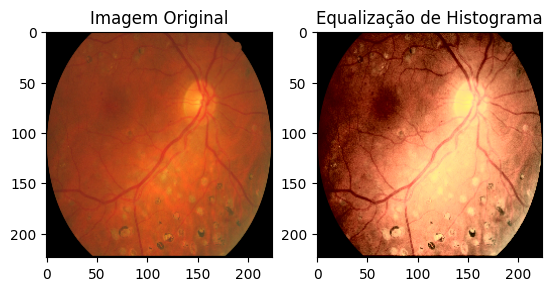

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def equalizacao_histograma(cv2_image):
  # Converter de RGB para YCrCb
  img_y_cr_cb = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2YCrCb)

  # Equalizar apenas o canal Y
  y, cr, cb = cv2.split(img_y_cr_cb)
  y_eq = cv2.equalizeHist(y)

  # Unir canais
  img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))

  # Converter de volta para RGB
  equalized_image = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCrCb2RGB)

  return equalized_image
# Processamento
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))

equalized_image = equalizacao_histograma(image)
# Exibir as imagens
plt.subplot(1, 2, 1), plt.imshow(image), plt.title('Imagem Original')
plt.subplot(1, 2, 2), plt.imshow(equalized_image), plt.title('Equalização de Histograma')
plt.show()

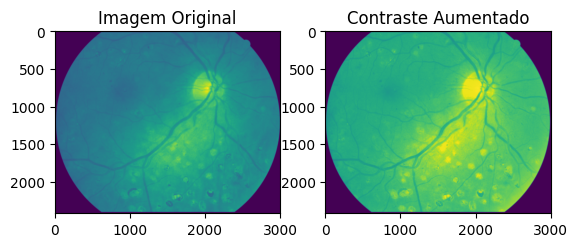

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def ajuste_Contraste(cv2_image, alpha:float=2.0, beta:int=0):
  # Aumento de contraste
  alpha = alpha  # Fator de contraste (1.0 para sem alteração)
  beta = beta    # Fator de brilho (0 para sem alteração)
  contrast_image = cv2.convertScaleAbs(cv2_image, alpha=alpha, beta=beta)
  return contrast_image


image = cv2.imread(path)
contrast_image = ajuste_Contraste(image)
# Exibir as imagens
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)), plt.title('Imagem Original')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(contrast_image, cv2.COLOR_BGR2GRAY)), plt.title('Contraste Aumentado')
plt.show()

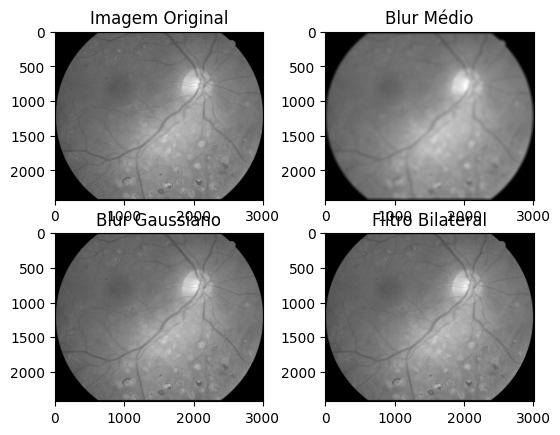

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def blur(cv2_image, type_blur:int=0, intensity:int=50):
  # Carregar a imagem
  image = cv2.imread(path)

  # Aplicar o filtro de desfoque médio
  if type_blur == 0:
    return cv2.blur(cv2_image, (intensity, intensity))
  elif type_blur == 1:
    # Aplicar o filtro de desfoque gaussiano
    return cv2.GaussianBlur(cv2_image, (5, 5), intensity)
  elif type_blur == 2:
    # Aplicar o filtro bilateral
    return cv2.bilateralFilter(cv2_image, 9, 75, 75)

image = cv2.imread(path)
# Exibir as imagens
plt.subplot(2, 2, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),cmap="gray"), plt.title('Imagem Original')
plt.subplot(2, 2, 2), plt.imshow(cv2.cvtColor(blur(image, type_blur=0), cv2.COLOR_BGR2GRAY),cmap="gray"), plt.title('Blur Médio')
plt.subplot(2, 2, 3), plt.imshow(cv2.cvtColor(blur(image, type_blur=1), cv2.COLOR_BGR2GRAY),cmap="gray"), plt.title('Blur Gaussiano')
plt.subplot(2, 2, 4), plt.imshow(cv2.cvtColor(blur(image, type_blur=2), cv2.COLOR_BGR2GRAY),cmap="gray"), plt.title('Filtro Bilateral')
plt.show()

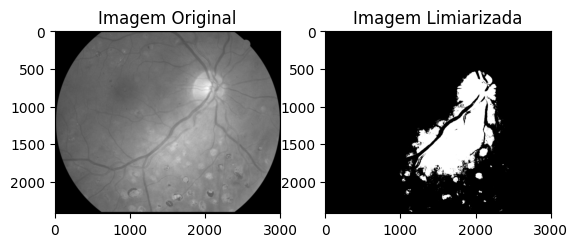

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def limiarizacao(cv2_image, intensity:int = 120):
  # Aplicar a limiarização simples
  _, threshold_image = cv2.threshold(cv2_image, intensity, 255, cv2.THRESH_BINARY)
  return threshold_image

image = cv2.imread(path, 0)
threshold_image = limiarizacao(image)
# Exibir as imagens
plt.subplot(1, 2, 1), plt.imshow(image, cmap='gray'), plt.title('Imagem Original')
plt.subplot(1, 2, 2), plt.imshow(threshold_image, cmap='gray'), plt.title('Imagem Limiarizada')
plt.show()

#3. Definição do Modelo


## Modelo 1
- conv
- pool
- conv
- pool
- conv
- pool
- flaten
- dense

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class model_v1(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(model_v1, self).__init__()

        # Primeira camada: Conv -> Pool
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda camada: Conv -> Pool
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Terceira camada: Conv -> Pool
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # A dimensão após flatten depende da entrada
        # Exemplo: se entrada for 3x64x64
        # Após Conv1+Pool: 16x32x32
        # Após Conv2+Pool: 32x16x16
        # Após Conv3+Pool: 64x8x8
        # Então flatten será 64*8*8 = 4096

        self.flatten = nn.Flatten()

        # Dense layer
        self.fc = nn.Linear(in_features=64*28*28, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc(x)

        return x

model = model_v1(input_channels=3, num_classes=10)
input_tensor = torch.randn(1, 3, 224, 224)  # Exemplo: batch 1, RGB, 224x224
output = model(input_tensor)
print(output.shape)  # [1, 10]

del model
del output

torch.Size([1, 10])


## Modelo 2

- conv
- pool
- conv
- pool
- conv
- pool
- flaten

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class model_v2(nn.Module):
  def __init__(self, input_channels, num_classes):
    super(model_v2, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=3, padding=1)
    self.pool3 = nn.AdaptiveAvgPool2d((1, 1))  # Reduz a feature map para 1x1

    self.flatten = nn.Flatten()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)

    x = F.relu(self.conv2(x))
    x = self.pool2(x)

    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    x = self.flatten(x)  # Agora [batch_size, num_classes]
    x = self.softmax(x)  # Probabilidades

    return x

model = model_v2(input_channels=3, num_classes=10)
input_tensor = torch.randn(1, 3, 224, 224)  # Exemplo: batch 1, RGB, 64x64
output = model(input_tensor)
print(output.shape)  # [1, 10]

del model
del output

torch.Size([1, 10])


## Modelo 3

- conv1
- conv2
- conv3
- conv4
- conv5
- conv6
- pool
- dense1
- dense2

In [ ]:

class model_v3(nn.Module):
  def __init__(self, input_channels, num_classes):
    super(model_v3, self).__init__()

    # Convoluções
    self.conv1 = nn.Conv2d(input_channels, 8, kernel_size=3, padding=1, stride=2)   # 224 → 112
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2)              # 112 → 56
    self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2)             # 56 → 28
    self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)             # 28 → 14
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)            # 14 → 7
    self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)

    # Pooling
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Dense layers
    # Flatten = 512 * 112 * 112 = 6422528

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(1024, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))

    x = self.pool(x) # Reduz para [B, 512, 112, 112]

    x = self.flatten(x)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

model = model_v3(input_channels=3, num_classes=10).to("cuda:0")
input_tensor = torch.randn(32, 3, 224, 224).to("cuda:0")  # Exemplo: batch 32, RGB, 224x224
output = model(input_tensor).to("cuda:0")
print(output.shape)  # [1, 10]

del model
del output
del input_tensor
import gc
gc.collect()
torch.cuda.empty_cache()
print(f"Memória alocada: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

torch.Size([32, 10])
Memória alocada: 0.01 GB


## Modelo 4

- conv1
- conv2
- conv3
- conv4
- conv5
- conv6
- flatten
- dense1

In [ ]:
class model_v4(nn.Module):
  def __init__(self, input_channels, num_classes):
    super(model_v4, self).__init__()

    # Seis camadas convolucionais
    self.conv1 = nn.Conv2d(input_channels, 8, kernel_size=3, padding=1, stride=2)   # 224 → 112
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2)              # 112 → 56
    self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2)             # 56 → 28
    self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)             # 28 → 14
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)            # 14 → 7
    self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2)

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(256* 4*4 , num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))

    x = self.flatten(x)

    x = self.fc1(x)

    return x

model = model_v4(input_channels=3, num_classes=10).to("cuda:0")
input_tensor = torch.randn(32, 3, 224, 224).to("cuda:0")  # Exemplo: batch 1, RGB, 224x224
output = model(input_tensor).to("cuda:0")
print(output.shape)  # [1, 10]

del model
del output
del input_tensor
import gc
gc.collect()
torch.cuda.empty_cache()
print(f"Memória alocada: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

torch.Size([32, 10])
Memória alocada: 0.01 GB


#4: Experimentação + Classificação + Medição
Vamos usar aqui a validação cruzada para estimar os parâmetros via GridSearch
Como classificador base, será usado o SVM

Uma porção dos dados será reservada para o teste (hold-out)

Outra opções de classificadores em https://scikit-learn.org/stable/supervised_learning.html

GridSearch (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Nested cross validation (https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)

#Estimação de parâmetros


*   usa validação cruzada no grid-search
*   e hold-out para o experimento como um todo

Observação: você pode também usar validação cruzada para o experimento como um todo



Criação do dataloader com o hold-out

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import random

def load_dataloader(test_size:float=0.1, pre_load_memory:bool=True, batch_size:int=32):
  # Criar o dataset
  dataset = CustomDataset(csv_file='/content/G1020/G1020.csv',
                          img_dir='/content/G1020/Images/',
                          pre_load_memory= pre_load_memory,
                          transform=equalizacao_histograma
                          )

  # Divisão Hold-out
  # Criar os índices para divisão
  indices = list(range(len(dataset)))
  train_indices, test_indices = train_test_split(
      indices, test_size=test_size, random_state=random.randrange(1,1000)
  )


  train_dataset = Subset(dataset, train_indices)
  test_dataset = Subset(dataset, test_indices)

  # Criar os DataLoaders
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

  return train_loader, test_loader

def load_dataloader_for_cross_validation(pre_load_memory:bool=True):
  dataset = CustomDataset(csv_file='/content/G1020/G1020.csv',
                          img_dir='/content/G1020/Images/',
                          pre_load_memory= pre_load_memory,
                          transform=equalizacao_histograma
                          )
  return dataset

train, test =load_dataloader()


#Verificando os dados
for images,labels in train:
    print(images.shape)
    break

torch.Size([32, 3, 224, 224])


In [ ]:
c0 = 0
c1 = 0
for images,labels in train:
  for i in labels:

    if i == 0:
      c0+=1
    else:
      c1+=1


print("Total imagens treinamento: ", c0+c1)
print("imagens negativa:",c0 ,"imagens positivas", c1)

Total imagens treinamento:  1303
imagens negativa: 657 imagens positivas 646


  Carregar modelo


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
def validate(model, val_loader, criterion, device="cpu"):
  model.eval()  # modo de avaliação
  y_true = []
  y_pred = []
  y_scores = []

  running_loss = 0.0

  print("Validação iniciada ...")

  with torch.no_grad():  # desliga autograd para validação
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)  # forward pass

      loss = criterion(outputs, labels)
      running_loss += loss.item()

      # Para classificações: pega a classe com maior probabilidade
      probs = torch.softmax(outputs, dim=1)
      preds = torch.argmax(probs, dim=1)

      y_true.extend(labels.cpu().numpy())
      y_pred.extend(preds.cpu().numpy())
      y_scores.extend(probs[:, 1].cpu().numpy() if probs.shape[1] > 1 else probs.squeeze().cpu().numpy())

  # Cálculo das métricas
  accuracy = np.mean(np.array(y_pred) == np.array(y_true))
  precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
  recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
  f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
  confusion_mat = confusion_matrix(y_true, y_pred)

  # AUC
  try:
      auc = roc_auc_score(y_true, y_scores, multi_class='ovo', average='macro')
  except ValueError:
      auc = None

  avg_loss = running_loss / len(val_loader)

  metrics = {
      "val_loss": avg_loss,
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1,
      "confusion_matrix": confusion_mat,
      "AUC": auc
  }

  print(metrics)
  print("Validação concluída com sucesso!")

  return metrics


def train(model, train_loader, criterion, optimizer, num_epochs=10, device="cpu"):

  print("Treinamento Iniciado ... ")
  model.train()  # Modo treinamento

  for epoch in tqdm(range(num_epochs)):
      running_loss = 0.0

      for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()               # Zera os gradientes acumulados
          outputs = model(images)             # Forward pass
          loss = criterion(outputs, labels)   # Cálculo da perda

          loss.backward()                     # Backward pass
          optimizer.step()                    # Atualiza os pesos

          running_loss += loss.item()

      avg_loss = running_loss / len(train_loader)
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

  print("Treinado com sucesso!")
  return model

In [ ]:
def load_model(index_model:int=1,device="cpu"):
  if index_model == 1 :
    model = model_v1(input_channels=3, num_classes=2).to(device)
  elif index_model == 2:
    model = model_v2(input_channels=3, num_classes=2).to(device)
  elif index_model ==3:
    model = model_v3(input_channels=3, num_classes=2).to(device)
  elif index_model == 4:
    model = model_v4(input_channels=3, num_classes=2).to(device)
  else:
    print("Modelo não carregado")
    return -1

  return model

def cross_validation(config,dataset,criterion):
  kfold = KFold(n_splits=config["kfold"], shuffle=True)
  results = []
  # Validacao cruzada
  for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'Fold {fold + 1}/{config["kfold"]}')

    # Criar subsets e DataLoaders
    train_subset = Subset(dataset, train_ids)
    val_subset = Subset(dataset, val_ids)

    train_loader = DataLoader(train_subset, batch_size=config["batch_size"], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=config["batch_size"], shuffle=False, num_workers=2)

    # Reinstanciar modelo e otimizador
    model = load_model(config["model"], device)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    # Treinar modelo
    trained_model = train(model, train_loader, criterion, optimizer, num_epochs=config["max_num_epochs"], device=device)

    # Validar modelo
    metrics = validate(trained_model, val_loader, criterion, device)

    if config["tune_use"]:
      tune.report(metrics)
    else:
      results.append(metrics)

  return results

def choose_loss(config):
  if config["loss"] == "cross_entropy":
    return nn.CrossEntropyLoss()
  else:
    print("Loss não carregada")
    return -1

In [ ]:
from sklearn.svm import SVC
from tqdm.auto import tqdm
import gc

def train_model(config):

  print('is cuda avaiable',torch.cuda.is_available())

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Inicialize o DataLoader
  print("Carregando DataLoader ...")
  if config["cross_validation"]:
    dataset = load_dataloader_for_cross_validation()
  else:
    train_loader, val_loader = load_dataloader(test_size=config["val_size"])

  # Carregar modelo
  print("Carregando modelo ...")
  model = load_model(config["model"], device)

  criterion = choose_loss(config)
  optimizer = optim.Adam(model.parameters(), lr=config["lr"])

  # Validação cruzada
  if config["cross_validation"]:

    results = cross_validation(config,dataset,criterion)
    print("Finished Cross-Validation!")

    return results

  # hold-out
  model = train(model, train_loader, criterion, optimizer, num_epochs=config["max_num_epochs"], device=device)
  metrics = validate(model, val_loader, criterion, device)


  del model
  torch.cuda.empty_cache()
  import gc
  gc.collect()  # Força a coleta de lixo


  print("Finished Training!")
  if config["tune_use"]:
    tune.report(metrics)
  else:
    return metrics


# Hold-out

GridSearch

In [ ]:
import torch.optim as optim
from ray import tune
import ray
from tqdm import tqdm
import torch
import torch.nn as nn
from ray.train import ScalingConfig
from ray.train.torch import TorchTrainer, get_device
from ray.tune.schedulers import ASHAScheduler
import tempfile

SMOKE_TEST = False
# Configuração de pesquisa de hiperparâmetros
config = {
    "loss": tune.grid_search(["cross_entropy"]),
    "model": tune.grid_search([1,2,3,4]),
    "lr": tune.grid_search([0.001]),
    "max_num_epochs": 10,
    "batch_size": 16,
    "kfold": 5,
    "num_trials": 2,
    "val_size": 0.2,
    "tune_use":True,
    "cross_validation":False
}



In [ ]:
import json
ray.shutdown()  # encerra sessão Ray atual, se houver
ray.init(
    _system_config={
        "object_spilling_config": json.dumps({
            "type": "filesystem",
            "params": {"directory_path": "/tmp/spill"}
        })
    }
)

2025-05-29 01:51:21,017	WARNING node.py:1904 -- The object spilling config is specified from an unstable API - system config or environment variable. This is subject to change in the future. You can use the stable API - --object-spilling-directory in ray start or object_spilling_directory in ray.init() to specify the object spilling directory instead. If you need more advanced settings, please open a github issue with the Ray team.
2025-05-29 01:51:24,152	INFO worker.py:1888 -- Started a local Ray instance.


Python version:,3.11.11
Ray version:,2.46.0


In [ ]:
# scheduler = ASHAScheduler(
#     time_attr="training_iteration",
#     max_t=config["max_num_epochs"],
#     grace_period=1,
#     reduction_factor=2)

gpus_per_trial = 1

tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_model),
        resources={"cpu": 2, "gpu": 1}
    ),
    tune_config=tune.TuneConfig(
        metric="val_loss",
        mode="min",
        # scheduler=scheduler,
        num_samples=config["num_trials"],

    ),
    param_space=config,
)

results = tuner.fit()

best_result = results.get_best_result("f1", "max")

print(f"Best trial config: {best_result.config}")
print(f"Best trial final validation F1_score: {best_result.metrics['f1']}")
print(f"Best trial final validation accuracy: {best_result.metrics['accuracy']}")

#test_best_model(best_result, smoke_test=config["smoke_test"])

2025-05-29 01:51:26,057	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2025-05-29 01:51:26,059	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2025-05-29_01-51-25   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 8                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2025-05-29_01-51-25

Trial status: 8 PENDING
Current time: 2025-05-29 01:51:26. Total running time: 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------+
| Trial name                status     loss              model      lr |
+----------------------------------------------------------------------+
| train_model_6e533_00000   PENDING    cross_

(pid=2242) /usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
(pid=2242)   check_for_updates()



Trial train_model_6e533_00000 started with configuration:
+--------------------------------------------------------+
| Trial train_model_6e533_00000 config                   |
+--------------------------------------------------------+
| batch_size                                          16 |
| cross_validation                                 False |
| kfold                                                5 |
| loss                                     cross_entropy |
| lr                                               0.001 |
| max_num_epochs                                      10 |
| model                                                1 |
| num_trials                                           2 |
| tune_use                                          True |
| val_size                                           0.2 |
+--------------------------------------------------------+
(train_model pid=2242) is cuda avaiable True
(train_model pid=2242) Carregando DataLoader ...

Trial status: 1 RUNN

  0%|          | 0/10 [00:00<?, ?it/s]


(train_model pid=2242) Treinamento Iniciado ... 
Trial status: 1 RUNNING | 7 PENDING
Current time: 2025-05-29 01:52:56. Total running time: 1min 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------+
| Trial name                status     loss              model      lr |
+----------------------------------------------------------------------+
| train_model_6e533_00000   RUNNING    cross_entropy         1   0.001 |
| train_model_6e533_00001   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00002   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00003   PENDING    cross_entropy         4   0.001 |
| train_model_6e533_00004   PENDING    cross_entropy         1   0.001 |
| train_model_6e533_00005   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00006   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00007   PENDING    cross

 10%|█         | 1/10 [00:50<07:32, 50.28s/it]


(train_model pid=2242) Epoch [1/10], Loss: 0.7676
Trial status: 1 RUNNING | 7 PENDING
Current time: 2025-05-29 01:53:57. Total running time: 2min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------+
| Trial name                status     loss              model      lr |
+----------------------------------------------------------------------+
| train_model_6e533_00000   RUNNING    cross_entropy         1   0.001 |
| train_model_6e533_00001   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00002   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00003   PENDING    cross_entropy         4   0.001 |
| train_model_6e533_00004   PENDING    cross_entropy         1   0.001 |
| train_model_6e533_00005   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00006   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00007   PENDING    cros

 20%|██        | 2/10 [01:28<05:47, 43.43s/it]


(train_model pid=2242) Epoch [2/10], Loss: 0.6741
Trial status: 1 RUNNING | 7 PENDING
Current time: 2025-05-29 01:54:27. Total running time: 3min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------+
| Trial name                status     loss              model      lr |
+----------------------------------------------------------------------+
| train_model_6e533_00000   RUNNING    cross_entropy         1   0.001 |
| train_model_6e533_00001   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00002   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00003   PENDING    cross_entropy         4   0.001 |
| train_model_6e533_00004   PENDING    cross_entropy         1   0.001 |
| train_model_6e533_00005   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00006   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00007   PENDING    cross

 30%|███       | 3/10 [02:08<04:50, 41.56s/it]


(train_model pid=2242) Epoch [3/10], Loss: 0.6495
Trial status: 1 RUNNING | 7 PENDING
Current time: 2025-05-29 01:54:57. Total running time: 3min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------+
| Trial name                status     loss              model      lr |
+----------------------------------------------------------------------+
| train_model_6e533_00000   RUNNING    cross_entropy         1   0.001 |
| train_model_6e533_00001   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00002   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00003   PENDING    cross_entropy         4   0.001 |
| train_model_6e533_00004   PENDING    cross_entropy         1   0.001 |
| train_model_6e533_00005   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00006   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00007   PENDING    cros

 40%|████      | 4/10 [02:47<04:04, 40.83s/it]


(train_model pid=2242) Epoch [4/10], Loss: 0.6042
Trial status: 1 RUNNING | 7 PENDING
Current time: 2025-05-29 01:55:57. Total running time: 4min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------+
| Trial name                status     loss              model      lr |
+----------------------------------------------------------------------+
| train_model_6e533_00000   RUNNING    cross_entropy         1   0.001 |
| train_model_6e533_00001   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00002   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00003   PENDING    cross_entropy         4   0.001 |
| train_model_6e533_00004   PENDING    cross_entropy         1   0.001 |
| train_model_6e533_00005   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00006   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00007   PENDING    cros

 50%|█████     | 5/10 [03:28<03:23, 40.75s/it]


(train_model pid=2242) Epoch [5/10], Loss: 0.5622
Trial status: 1 RUNNING | 7 PENDING
Current time: 2025-05-29 01:56:27. Total running time: 5min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------+
| Trial name                status     loss              model      lr |
+----------------------------------------------------------------------+
| train_model_6e533_00000   RUNNING    cross_entropy         1   0.001 |
| train_model_6e533_00001   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00002   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00003   PENDING    cross_entropy         4   0.001 |
| train_model_6e533_00004   PENDING    cross_entropy         1   0.001 |
| train_model_6e533_00005   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00006   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00007   PENDING    cross

 60%|██████    | 6/10 [04:08<02:42, 40.53s/it]


(train_model pid=2242) Epoch [6/10], Loss: 0.5419
Trial status: 1 RUNNING | 7 PENDING
Current time: 2025-05-29 01:56:57. Total running time: 5min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------+
| Trial name                status     loss              model      lr |
+----------------------------------------------------------------------+
| train_model_6e533_00000   RUNNING    cross_entropy         1   0.001 |
| train_model_6e533_00001   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00002   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00003   PENDING    cross_entropy         4   0.001 |
| train_model_6e533_00004   PENDING    cross_entropy         1   0.001 |
| train_model_6e533_00005   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00006   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00007   PENDING    cros

 70%|███████   | 7/10 [04:48<02:00, 40.19s/it]


(train_model pid=2242) Epoch [7/10], Loss: 0.5045
Trial status: 1 RUNNING | 7 PENDING
Current time: 2025-05-29 01:57:57. Total running time: 6min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------+
| Trial name                status     loss              model      lr |
+----------------------------------------------------------------------+
| train_model_6e533_00000   RUNNING    cross_entropy         1   0.001 |
| train_model_6e533_00001   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00002   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00003   PENDING    cross_entropy         4   0.001 |
| train_model_6e533_00004   PENDING    cross_entropy         1   0.001 |
| train_model_6e533_00005   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00006   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00007   PENDING    cros

 80%|████████  | 8/10 [05:27<01:20, 40.04s/it]


(train_model pid=2242) Epoch [8/10], Loss: 0.4561
Trial status: 1 RUNNING | 7 PENDING
Current time: 2025-05-29 01:58:27. Total running time: 7min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------+
| Trial name                status     loss              model      lr |
+----------------------------------------------------------------------+
| train_model_6e533_00000   RUNNING    cross_entropy         1   0.001 |
| train_model_6e533_00001   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00002   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00003   PENDING    cross_entropy         4   0.001 |
| train_model_6e533_00004   PENDING    cross_entropy         1   0.001 |
| train_model_6e533_00005   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00006   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00007   PENDING    cross

 90%|█████████ | 9/10 [06:07<00:39, 39.88s/it]


(train_model pid=2242) Epoch [9/10], Loss: 0.4140
Trial status: 1 RUNNING | 7 PENDING
Current time: 2025-05-29 01:58:57. Total running time: 7min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------+
| Trial name                status     loss              model      lr |
+----------------------------------------------------------------------+
| train_model_6e533_00000   RUNNING    cross_entropy         1   0.001 |
| train_model_6e533_00001   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00002   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00003   PENDING    cross_entropy         4   0.001 |
| train_model_6e533_00004   PENDING    cross_entropy         1   0.001 |
| train_model_6e533_00005   PENDING    cross_entropy         2   0.001 |
| train_model_6e533_00006   PENDING    cross_entropy         3   0.001 |
| train_model_6e533_00007   PENDING    cros

100%|██████████| 10/10 [06:45<00:00, 40.58s/it]


(train_model pid=2242) Epoch [10/10], Loss: 0.3930
(train_model pid=2242) Treinado com sucesso!
(train_model pid=2242) Validação iniciada ...
(train_model pid=2242) {'val_loss': 0.6216252535581589, 'accuracy': 0.7, 'precision': 0.7019464720194647, 'recall': 0.7018020594965675, 'f1': 0.6999964327756573, 'confusion_matrix': array([[101,  51],
(train_model pid=2242)        [ 36, 102]]), 'AUC': 0.7920480549199085}
(train_model pid=2242) Validação concluída com sucesso!
(train_model pid=2242) Finished Training!

Trial train_model_6e533_00000 completed after 1 iterations at 2025-05-29 01:59:45. Total running time: 8min 19s
+----------------------------------------------------+
| Trial train_model_6e533_00000 result               |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                         493.30187 |
| time_total_s                             493.30187 |
| training_iteration                         

(pid=4533) /usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
(pid=4533)   check_for_updates()



Trial train_model_6e533_00001 started with configuration:
+--------------------------------------------------------+
| Trial train_model_6e533_00001 config                   |
+--------------------------------------------------------+
| batch_size                                          16 |
| cross_validation                                 False |
| kfold                                                5 |
| loss                                     cross_entropy |
| lr                                               0.001 |
| max_num_epochs                                      10 |
| model                                                2 |
| num_trials                                           2 |
| tune_use                                          True |
| val_size                                           0.2 |
+--------------------------------------------------------+
(train_model pid=4533) is cuda avaiable True
(train_model pid=4533) Carregando DataLoader ...

Trial status: 1 TERM

  0%|          | 0/10 [00:00<?, ?it/s]


(train_model pid=4533) Treinamento Iniciado ... 
Trial status: 1 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-05-29 02:01:28. Total running time: 10min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00001   RUNNING    

 10%|█         | 1/10 [00:45<06:46, 45.16s/it]


(train_model pid=4533) Epoch [1/10], Loss: 0.6942
Trial status: 1 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-05-29 02:01:58. Total running time: 10min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00001   RUNNING  

 20%|██        | 2/10 [01:24<05:34, 41.81s/it]


(train_model pid=4533) Epoch [2/10], Loss: 0.6930
Trial status: 1 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-05-29 02:02:58. Total running time: 11min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00001   RUNNING  

 30%|███       | 3/10 [02:05<04:49, 41.40s/it]


(train_model pid=4533) Epoch [3/10], Loss: 0.6930
Trial status: 1 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-05-29 02:03:28. Total running time: 12min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00001   RUNNING   

 40%|████      | 4/10 [02:47<04:08, 41.46s/it]


(train_model pid=4533) Epoch [4/10], Loss: 0.6930
Trial status: 1 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-05-29 02:03:58. Total running time: 12min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00001   RUNNING  

 50%|█████     | 5/10 [03:26<03:23, 40.79s/it]


(train_model pid=4533) Epoch [5/10], Loss: 0.6924
Trial status: 1 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-05-29 02:04:58. Total running time: 13min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00001   RUNNING  

 60%|██████    | 6/10 [04:07<02:43, 40.86s/it]


(train_model pid=4533) Epoch [6/10], Loss: 0.6925
Trial status: 1 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-05-29 02:05:28. Total running time: 14min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00001   RUNNING   

 70%|███████   | 7/10 [04:46<02:00, 40.19s/it]


(train_model pid=4533) Epoch [7/10], Loss: 0.6917
Trial status: 1 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-05-29 02:05:58. Total running time: 14min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00001   RUNNING  

 80%|████████  | 8/10 [05:25<01:19, 39.91s/it]


Trial status: 1 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-05-29 02:06:58. Total running time: 15min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00001   RUNNING      cross_entropy         2   0.001               

 90%|█████████ | 9/10 [06:06<00:40, 40.29s/it]


(train_model pid=4533) Epoch [9/10], Loss: 0.6915
Trial status: 1 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-05-29 02:07:28. Total running time: 16min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00001   RUNNING   

100%|██████████| 10/10 [06:47<00:00, 40.78s/it]


(train_model pid=4533) Epoch [10/10], Loss: 0.6910
(train_model pid=4533) Treinado com sucesso!
(train_model pid=4533) Validação iniciada ...
Trial status: 1 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-05-29 02:07:58. Total running time: 16min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+--------------------------------------------------------------------------------------------------

(pid=6789) /usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
(pid=6789)   check_for_updates()



Trial train_model_6e533_00002 started with configuration:
+--------------------------------------------------------+
| Trial train_model_6e533_00002 config                   |
+--------------------------------------------------------+
| batch_size                                          16 |
| cross_validation                                 False |
| kfold                                                5 |
| loss                                     cross_entropy |
| lr                                               0.001 |
| max_num_epochs                                      10 |
| model                                                3 |
| num_trials                                           2 |
| tune_use                                          True |
| val_size                                           0.2 |
+--------------------------------------------------------+
(train_model pid=6789) is cuda avaiable True
(train_model pid=6789) Carregando DataLoader ...

Trial status: 2 TERM

  0%|          | 0/10 [00:00<?, ?it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-05-29 02:09:28. Total running time: 18min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00002   RUNNING      cross_entropy         3   0.001                

 10%|█         | 1/10 [00:49<07:22, 49.14s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-05-29 02:10:29. Total running time: 19min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00002   RUNNING      cross_entropy         3   0.001                

 20%|██        | 2/10 [01:29<05:52, 44.10s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-05-29 02:10:59. Total running time: 19min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00002   RUNNING      cross_entropy         3   0.001               

 30%|███       | 3/10 [02:10<04:59, 42.76s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-05-29 02:11:59. Total running time: 20min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00002   RUNNING      cross_entropy         3   0.001               

 40%|████      | 4/10 [02:51<04:11, 41.89s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-05-29 02:12:29. Total running time: 21min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00002   RUNNING      cross_entropy         3   0.001                

 50%|█████     | 5/10 [03:34<03:31, 42.29s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-05-29 02:13:29. Total running time: 22min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00002   RUNNING      cross_entropy         3   0.001                

 60%|██████    | 6/10 [04:15<02:47, 41.86s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-05-29 02:13:59. Total running time: 22min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00002   RUNNING      cross_entropy         3   0.001               

 70%|███████   | 7/10 [04:55<02:03, 41.27s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-05-29 02:14:29. Total running time: 23min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00002   RUNNING      cross_entropy         3   0.001                

 80%|████████  | 8/10 [05:36<01:22, 41.23s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-05-29 02:15:29. Total running time: 24min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00002   RUNNING      cross_entropy         3   0.001                

 90%|█████████ | 9/10 [06:16<00:40, 40.87s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-05-29 02:15:59. Total running time: 24min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00002   RUNNING      cross_entropy         3   0.001               

100%|██████████| 10/10 [06:56<00:00, 41.64s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-05-29 02:16:30. Total running time: 25min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00000 with val_loss=0.6216252535581589 and params={'loss': 'cross_entropy', 'model': 1, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00002   RUNNING      cross_entropy         3   0.001                

(pid=9075) /usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
(pid=9075)   check_for_updates()



Trial train_model_6e533_00003 started with configuration:
+--------------------------------------------------------+
| Trial train_model_6e533_00003 config                   |
+--------------------------------------------------------+
| batch_size                                          16 |
| cross_validation                                 False |
| kfold                                                5 |
| loss                                     cross_entropy |
| lr                                               0.001 |
| max_num_epochs                                      10 |
| model                                                4 |
| num_trials                                           2 |
| tune_use                                          True |
| val_size                                           0.2 |
+--------------------------------------------------------+
(train_model pid=9075) is cuda avaiable True
(train_model pid=9075) Carregando DataLoader ...

Trial status: 3 TERM

  0%|          | 0/10 [00:00<?, ?it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-05-29 02:18:00. Total running time: 26min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00002 with val_loss=0.5924578964710235 and params={'loss': 'cross_entropy', 'model': 3, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00003   RUNNING      cross_entropy         4   0.001               

 10%|█         | 1/10 [00:45<06:51, 45.74s/it]


Trial status: 3 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-05-29 02:19:00. Total running time: 27min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00002 with val_loss=0.5924578964710235 and params={'loss': 'cross_entropy', 'model': 3, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00003   RUNNING      cross_entropy         4   0.001               

 20%|██        | 2/10 [01:25<05:36, 42.07s/it]


Trial status: 3 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-05-29 02:19:30. Total running time: 28min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00002 with val_loss=0.5924578964710235 and params={'loss': 'cross_entropy', 'model': 3, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00003   RUNNING      cross_entropy         4   0.001                

 30%|███       | 3/10 [02:04<04:45, 40.80s/it]


Trial status: 3 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-05-29 02:20:00. Total running time: 28min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00002 with val_loss=0.5924578964710235 and params={'loss': 'cross_entropy', 'model': 3, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00003   RUNNING      cross_entropy         4   0.001               

 40%|████      | 4/10 [02:44<04:02, 40.46s/it]


Trial status: 3 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-05-29 02:21:00. Total running time: 29min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00002 with val_loss=0.5924578964710235 and params={'loss': 'cross_entropy', 'model': 3, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00003   RUNNING      cross_entropy         4   0.001               

 50%|█████     | 5/10 [03:23<03:20, 40.00s/it]


Trial status: 3 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-05-29 02:21:30. Total running time: 30min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00002 with val_loss=0.5924578964710235 and params={'loss': 'cross_entropy', 'model': 3, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00003   RUNNING      cross_entropy         4   0.001                

 60%|██████    | 6/10 [04:03<02:39, 39.85s/it]


Trial status: 3 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-05-29 02:22:00. Total running time: 30min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00002 with val_loss=0.5924578964710235 and params={'loss': 'cross_entropy', 'model': 3, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00003   RUNNING      cross_entropy         4   0.001               

 70%|███████   | 7/10 [04:42<01:59, 39.75s/it]


Trial status: 3 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-05-29 02:23:01. Total running time: 31min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00002 with val_loss=0.5924578964710235 and params={'loss': 'cross_entropy', 'model': 3, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00003   RUNNING      cross_entropy         4   0.001               

 80%|████████  | 8/10 [05:22<01:19, 39.61s/it]


Trial status: 3 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-05-29 02:23:31. Total running time: 32min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00002 with val_loss=0.5924578964710235 and params={'loss': 'cross_entropy', 'model': 3, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00003   RUNNING      cross_entropy         4   0.001                

 90%|█████████ | 9/10 [06:01<00:39, 39.55s/it]


Trial status: 3 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-05-29 02:24:01. Total running time: 32min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00002 with val_loss=0.5924578964710235 and params={'loss': 'cross_entropy', 'model': 3, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00003   RUNNING      cross_entropy         4   0.001               

100%|██████████| 10/10 [06:42<00:00, 40.25s/it]


(train_model pid=9075) {'val_loss': 0.5805346250534058, 'accuracy': 0.7206896551724138, 'precision': 0.7327950310559006, 'recall': 0.7229253901789113, 'f1': 0.7182473521968071, 'confusion_matrix': array([[118,  24],
(train_model pid=9075)        [ 57,  91]]), 'AUC': 0.7836410354015988}
(train_model pid=9075) Validação concluída com sucesso!

Trial train_model_6e533_00003 completed after 1 iterations at 2025-05-29 02:24:47. Total running time: 33min 21s
+----------------------------------------------------+
| Trial train_model_6e533_00003 result               |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                         486.85028 |
| time_total_s                             486.85028 |
| training_iteration                               1 |
| AUC                                        0.78364 |
| accuracy                                   0.72069 |
| confusion_matrix                              

(pid=11310) /usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
(pid=11310)   check_for_updates()



Trial train_model_6e533_00004 started with configuration:
+--------------------------------------------------------+
| Trial train_model_6e533_00004 config                   |
+--------------------------------------------------------+
| batch_size                                          16 |
| cross_validation                                 False |
| kfold                                                5 |
| loss                                     cross_entropy |
| lr                                               0.001 |
| max_num_epochs                                      10 |
| model                                                1 |
| num_trials                                           2 |
| tune_use                                          True |
| val_size                                           0.2 |
+--------------------------------------------------------+
(train_model pid=11310) is cuda avaiable True
(train_model pid=11310) Carregando DataLoader ...

Trial status: 4 TE

  0%|          | 0/10 [00:00<?, ?it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-29 02:26:31. Total running time: 35min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00004   RUNNING      cross_entropy         1   0.001                

 10%|█         | 1/10 [00:45<06:52, 45.88s/it]


Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-29 02:27:01. Total running time: 35min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00004   RUNNING      cross_entropy         1   0.001               

 20%|██        | 2/10 [01:26<05:39, 42.49s/it]


Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-29 02:28:01. Total running time: 36min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00004   RUNNING      cross_entropy         1   0.001               

 30%|███       | 3/10 [02:07<04:54, 42.12s/it]


Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-29 02:28:31. Total running time: 37min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00004   RUNNING      cross_entropy         1   0.001                

 40%|████      | 4/10 [02:48<04:08, 41.42s/it]


Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-29 02:29:01. Total running time: 37min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00004   RUNNING      cross_entropy         1   0.001               

 50%|█████     | 5/10 [03:28<03:24, 40.92s/it]


Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-29 02:30:02. Total running time: 38min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00004   RUNNING      cross_entropy         1   0.001               

 60%|██████    | 6/10 [04:07<02:41, 40.43s/it]


Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-29 02:30:32. Total running time: 39min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00004   RUNNING      cross_entropy         1   0.001                

 70%|███████   | 7/10 [04:46<02:00, 40.09s/it]


Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-29 02:31:02. Total running time: 39min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00004   RUNNING      cross_entropy         1   0.001               

 80%|████████  | 8/10 [05:28<01:20, 40.45s/it]


Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-29 02:32:02. Total running time: 40min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00004   RUNNING      cross_entropy         1   0.001               

 90%|█████████ | 9/10 [06:08<00:40, 40.31s/it]


Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-29 02:32:32. Total running time: 41min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00004   RUNNING      cross_entropy         1   0.001                

100%|██████████| 10/10 [06:48<00:00, 40.83s/it]


Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-05-29 02:33:02. Total running time: 41min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00004   RUNNING      cross_entropy         1   0.001               

(pid=13561) /usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
(pid=13561)   check_for_updates()



Trial train_model_6e533_00005 started with configuration:
+--------------------------------------------------------+
| Trial train_model_6e533_00005 config                   |
+--------------------------------------------------------+
| batch_size                                          16 |
| cross_validation                                 False |
| kfold                                                5 |
| loss                                     cross_entropy |
| lr                                               0.001 |
| max_num_epochs                                      10 |
| model                                                2 |
| num_trials                                           2 |
| tune_use                                          True |
| val_size                                           0.2 |
+--------------------------------------------------------+
(train_model pid=13561) is cuda avaiable True
(train_model pid=13561) Carregando DataLoader ...

Trial status: 5 TE

  0%|          | 0/10 [00:00<?, ?it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-29 02:34:32. Total running time: 43min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00005   RUNNING      cross_entropy         2   0.001                

 10%|█         | 1/10 [00:48<07:19, 48.88s/it]


Trial status: 5 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-29 02:35:32. Total running time: 44min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00005   RUNNING      cross_entropy         2   0.001                

 20%|██        | 2/10 [01:29<05:50, 43.86s/it]


Trial status: 5 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-29 02:36:02. Total running time: 44min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00005   RUNNING      cross_entropy         2   0.001               

 30%|███       | 3/10 [02:12<05:05, 43.63s/it]


Trial status: 5 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-29 02:37:02. Total running time: 45min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00005   RUNNING      cross_entropy         2   0.001               

 40%|████      | 4/10 [02:53<04:15, 42.53s/it]


Trial status: 5 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-29 02:37:32. Total running time: 46min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00005   RUNNING      cross_entropy         2   0.001                

 50%|█████     | 5/10 [03:33<03:28, 41.73s/it]


Trial status: 5 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-29 02:38:03. Total running time: 46min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00005   RUNNING      cross_entropy         2   0.001               

 60%|██████    | 6/10 [04:14<02:45, 41.49s/it]


Trial status: 5 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-29 02:39:03. Total running time: 47min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00005   RUNNING      cross_entropy         2   0.001               

 70%|███████   | 7/10 [04:54<02:03, 41.04s/it]


Trial status: 5 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-29 02:39:33. Total running time: 48min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00005   RUNNING      cross_entropy         2   0.001                

 80%|████████  | 8/10 [05:34<01:21, 40.50s/it]


Trial status: 5 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-29 02:40:03. Total running time: 48min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00005   RUNNING      cross_entropy         2   0.001               

 90%|█████████ | 9/10 [06:13<00:40, 40.08s/it]


Trial status: 5 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-05-29 02:41:03. Total running time: 49min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00005   RUNNING      cross_entropy         2   0.001               

100%|██████████| 10/10 [06:53<00:00, 41.32s/it]


(train_model pid=13561) {'val_loss': 0.6931474506855011, 'accuracy': 0.47586206896551725, 'precision': 0.23793103448275862, 'recall': 0.5, 'f1': 0.32242990654205606, 'confusion_matrix': array([[138,   0],
(train_model pid=13561)        [152,   0]]), 'AUC': 0.5}
(train_model pid=13561) Validação concluída com sucesso!
(train_model pid=13561) Finished Training!

Trial train_model_6e533_00005 completed after 1 iterations at 2025-05-29 02:41:32. Total running time: 50min 6s
+----------------------------------------------------+
| Trial train_model_6e533_00005 result               |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                         499.00069 |
| time_total_s                             499.00069 |
| training_iteration                               1 |
| AUC                                            0.5 |
| accuracy                                   0.47586 |
| confusion_matrix            

(pid=15843) /usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
(pid=15843)   check_for_updates()



Trial train_model_6e533_00006 started with configuration:
+--------------------------------------------------------+
| Trial train_model_6e533_00006 config                   |
+--------------------------------------------------------+
| batch_size                                          16 |
| cross_validation                                 False |
| kfold                                                5 |
| loss                                     cross_entropy |
| lr                                               0.001 |
| max_num_epochs                                      10 |
| model                                                3 |
| num_trials                                           2 |
| tune_use                                          True |
| val_size                                           0.2 |
+--------------------------------------------------------+
(train_model pid=15843) is cuda avaiable True
(train_model pid=15843) Carregando DataLoader ...

Trial status: 6 TE

  0%|          | 0/10 [00:00<?, ?it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-29 02:43:03. Total running time: 51min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00006   RUNNING      cross_entropy         3   0.001               

 10%|█         | 1/10 [00:46<07:02, 46.93s/it]


Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-29 02:44:03. Total running time: 52min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00006   RUNNING      cross_entropy         3   0.001               

 20%|██        | 2/10 [01:27<05:46, 43.30s/it]


Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-29 02:44:33. Total running time: 53min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00006   RUNNING      cross_entropy         3   0.001                

 30%|███       | 3/10 [02:07<04:52, 41.84s/it]


Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-29 02:45:03. Total running time: 53min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00006   RUNNING      cross_entropy         3   0.001               

 40%|████      | 4/10 [02:48<04:08, 41.43s/it]


Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-29 02:46:03. Total running time: 54min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00006   RUNNING      cross_entropy         3   0.001               

 50%|█████     | 5/10 [03:28<03:25, 41.01s/it]


Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-29 02:46:33. Total running time: 55min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00006   RUNNING      cross_entropy         3   0.001                

 60%|██████    | 6/10 [04:12<02:48, 42.07s/it]


Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-29 02:47:34. Total running time: 56min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00006   RUNNING      cross_entropy         3   0.001                

 70%|███████   | 7/10 [04:52<02:03, 41.32s/it]


Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-29 02:48:04. Total running time: 56min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00006   RUNNING      cross_entropy         3   0.001               

 80%|████████  | 8/10 [05:32<01:21, 40.90s/it]


Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-29 02:48:34. Total running time: 57min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00006   RUNNING      cross_entropy         3   0.001                

 90%|█████████ | 9/10 [06:11<00:40, 40.18s/it]


Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-05-29 02:49:34. Total running time: 58min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00006   RUNNING      cross_entropy         3   0.001                

100%|██████████| 10/10 [06:54<00:00, 41.49s/it]


(train_model pid=15843) {'val_loss': 0.5911502450704574, 'accuracy': 0.6862068965517242, 'precision': 0.7264614376944489, 'recall': 0.6980996944232238, 'f1': 0.6791528370475739, 'confusion_matrix': array([[121,  15],
(train_model pid=15843)        [ 76,  78]]), 'AUC': 0.7494270435446906}
(train_model pid=15843) Validação concluída com sucesso!

Trial train_model_6e533_00006 completed after 1 iterations at 2025-05-29 02:49:59. Total running time: 58min 33s
+----------------------------------------------------+
| Trial train_model_6e533_00006 result               |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                         499.53658 |
| time_total_s                             499.53658 |
| training_iteration                               1 |
| AUC                                        0.74943 |
| accuracy                                   0.68621 |
| confusion_matrix                           

(pid=18131) /usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
(pid=18131)   check_for_updates()



Trial train_model_6e533_00007 started with configuration:
+--------------------------------------------------------+
| Trial train_model_6e533_00007 config                   |
+--------------------------------------------------------+
| batch_size                                          16 |
| cross_validation                                 False |
| kfold                                                5 |
| loss                                     cross_entropy |
| lr                                               0.001 |
| max_num_epochs                                      10 |
| model                                                4 |
| num_trials                                           2 |
| tune_use                                          True |
| val_size                                           0.2 |
+--------------------------------------------------------+
(train_model pid=18131) is cuda avaiable True
(train_model pid=18131) Carregando DataLoader ...

Trial status: 7 TE

  0%|          | 0/10 [00:00<?, ?it/s]


(train_model pid=18131) Treinamento Iniciado ... 
Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2025-05-29 02:51:34. Total running time: 1hr 0min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00007   RUNNING      cross_

 10%|█         | 1/10 [00:46<06:57, 46.38s/it]


(train_model pid=18131) Epoch [1/10], Loss: 0.6948
Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2025-05-29 02:52:34. Total running time: 1hr 1min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00007   RUNNING      cross

 20%|██        | 2/10 [01:33<06:14, 46.77s/it]


(train_model pid=18131) Epoch [2/10], Loss: 0.6928
Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2025-05-29 02:53:04. Total running time: 1hr 1min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00007   RUNNING      cros

 30%|███       | 3/10 [02:18<05:20, 45.80s/it]


(train_model pid=18131) Epoch [3/10], Loss: 0.6860
Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2025-05-29 02:54:04. Total running time: 1hr 2min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00007   RUNNING      cros

 40%|████      | 4/10 [03:05<04:37, 46.30s/it]


(train_model pid=18131) Epoch [4/10], Loss: 0.6775
Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2025-05-29 02:54:34. Total running time: 1hr 3min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00007   RUNNING      cross

 50%|█████     | 5/10 [03:49<03:48, 45.69s/it]


(train_model pid=18131) Epoch [5/10], Loss: 0.6418
Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2025-05-29 02:55:34. Total running time: 1hr 4min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00007   RUNNING      cross

 60%|██████    | 6/10 [04:34<03:01, 45.45s/it]


(train_model pid=18131) Epoch [6/10], Loss: 0.6158
Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2025-05-29 02:56:04. Total running time: 1hr 4min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00007   RUNNING      cros

 70%|███████   | 7/10 [05:24<02:20, 46.84s/it]


(train_model pid=18131) Epoch [7/10], Loss: 0.5824
Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2025-05-29 02:57:05. Total running time: 1hr 5min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00007   RUNNING      cros

 80%|████████  | 8/10 [06:08<01:31, 45.90s/it]


(train_model pid=18131) Epoch [8/10], Loss: 0.5732
Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2025-05-29 02:57:35. Total running time: 1hr 6min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00007   RUNNING      cross

 90%|█████████ | 9/10 [06:55<00:46, 46.34s/it]


(train_model pid=18131) Epoch [9/10], Loss: 0.5143
Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2025-05-29 02:58:35. Total running time: 1hr 7min 9s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 6e533_00003 with val_loss=0.5805346250534058 and params={'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': True, 'cross_validation': False}
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       loss              model      lr     iter     total time (s)     val_loss     accuracy     precision     recall |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6e533_00007   RUNNING      cross

100%|██████████| 10/10 [07:45<00:00, 46.53s/it]


(train_model pid=18131) Epoch [10/10], Loss: 0.4795
(train_model pid=18131) Treinado com sucesso!
(train_model pid=18131) Validação iniciada ...


2025-05-29 02:59:19,463	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2025-05-29_01-51-25' in 0.0072s.


(train_model pid=18131) {'val_loss': 0.6166563719511032, 'accuracy': 0.7379310344827587, 'precision': 0.8117354740061162, 'recall': 0.7328226113437382, 'f1': 0.7186047699300342, 'confusion_matrix': array([[145,   3],
(train_model pid=18131)        [ 73,  69]]), 'AUC': 0.7428149980966884}
(train_model pid=18131) Validação concluída com sucesso!

Trial train_model_6e533_00007 completed after 1 iterations at 2025-05-29 02:59:19. Total running time: 1hr 7min 53s
+----------------------------------------------------+
| Trial train_model_6e533_00007 result               |
+----------------------------------------------------+
| checkpoint_dir_name                                |
| time_this_iter_s                         552.30098 |
| time_total_s                             552.30098 |
| training_iteration                               1 |
| AUC                                        0.74281 |
| accuracy                                   0.73793 |
| confusion_matrix                        

In [ ]:
best_result.config["tune_use"] = False

n_repets = 5
# Armazena os resultados de cada repetição
all_metrics_hold = []

for i in range(n_repets):
  print(f"Executando repetição {i+1}/{n_repets}")
  metrics = train_model(best_result.config)  # Você precisa retornar essas métricas ao final da função
  all_metrics_hold.append(metrics)


Executando repetição 1/5
is cuda avaiable True
Carregando DataLoader ...
(train_model pid=18131) Finished Training!
Carregando modelo ...
Treinamento Iniciado ... 


 10%|█         | 1/10 [00:39<05:54, 39.39s/it]

Epoch [1/10], Loss: 0.6946


 20%|██        | 2/10 [01:18<05:15, 39.39s/it]

Epoch [2/10], Loss: 0.6914


 30%|███       | 3/10 [01:57<04:34, 39.28s/it]

Epoch [3/10], Loss: 0.6899


 40%|████      | 4/10 [02:37<03:56, 39.38s/it]

Epoch [4/10], Loss: 0.6881


 50%|█████     | 5/10 [03:16<03:17, 39.42s/it]

Epoch [5/10], Loss: 0.6830


 60%|██████    | 6/10 [03:57<02:39, 39.96s/it]

Epoch [6/10], Loss: 0.6593


 70%|███████   | 7/10 [04:36<01:58, 39.40s/it]

Epoch [7/10], Loss: 0.6525


 80%|████████  | 8/10 [05:15<01:18, 39.29s/it]

Epoch [8/10], Loss: 0.6477


 90%|█████████ | 9/10 [05:54<00:39, 39.36s/it]

Epoch [9/10], Loss: 0.6162


100%|██████████| 10/10 [06:34<00:00, 39.42s/it]

Epoch [10/10], Loss: 0.6033
Treinado com sucesso!
Validação iniciada ...


{'val_loss': 0.6410683214664459, 'accuracy': 0.6344827586206897, 'precision': 0.6373663101604279, 'recall': 0.6376291618828932, 'f1': 0.6344653729071537, 'confusion_matrix': array([[91, 43],
       [63, 93]]), 'AUC': 0.6620264064293915}
Validação concluída com sucesso!
Finished Training!
Executando repetição 2/5
is cuda avaiable True
Carregando DataLoader ...
Carregando modelo ...
Treinamento Iniciado ... 


 10%|█         | 1/10 [00:39<05:52, 39.19s/it]

Epoch [1/10], Loss: 0.6947


 20%|██        | 2/10 [01:18<05:14, 39.30s/it]

Epoch [2/10], Loss: 0.6936


 30%|███       | 3/10 [01:57<04:33, 39.12s/it]

Epoch [3/10], Loss: 0.6913


 40%|████      | 4/10 [02:36<03:53, 38.91s/it]

Epoch [4/10], Loss: 0.6785


 50%|█████     | 5/10 [03:15<03:16, 39.22s/it]

Epoch [5/10], Loss: 0.6926


 60%|██████    | 6/10 [03:54<02:36, 39.17s/it]

Epoch [6/10], Loss: 0.6716


 70%|███████   | 7/10 [04:34<01:57, 39.15s/it]

Epoch [7/10], Loss: 0.6585


 80%|████████  | 8/10 [05:13<01:18, 39.10s/it]

Epoch [8/10], Loss: 0.6182


 90%|█████████ | 9/10 [05:51<00:38, 38.88s/it]

Epoch [9/10], Loss: 0.5916


100%|██████████| 10/10 [06:31<00:00, 39.18s/it]

Epoch [10/10], Loss: 0.5616
Treinado com sucesso!
Validação iniciada ...


{'val_loss': 0.5379553079605103, 'accuracy': 0.6896551724137931, 'precision': 0.7054597701149425, 'recall': 0.6983830845771144, 'f1': 0.6884549274255156, 'confusion_matrix': array([[109,  25],
       [ 65,  91]]), 'AUC': 0.746268656716418}
Validação concluída com sucesso!
Finished Training!
Executando repetição 3/5
is cuda avaiable True
Carregando DataLoader ...
Carregando modelo ...
Treinamento Iniciado ... 


 10%|█         | 1/10 [00:39<05:55, 39.44s/it]

Epoch [1/10], Loss: 0.6944


 20%|██        | 2/10 [01:18<05:14, 39.37s/it]

Epoch [2/10], Loss: 0.6926


 30%|███       | 3/10 [01:57<04:32, 38.87s/it]

Epoch [3/10], Loss: 0.6837


 40%|████      | 4/10 [02:37<03:57, 39.59s/it]

Epoch [4/10], Loss: 0.6885


 50%|█████     | 5/10 [03:17<03:17, 39.49s/it]

Epoch [5/10], Loss: 0.6765


 60%|██████    | 6/10 [03:56<02:37, 39.43s/it]

Epoch [6/10], Loss: 0.6596


 70%|███████   | 7/10 [04:35<01:58, 39.49s/it]

Epoch [7/10], Loss: 0.6377


 80%|████████  | 8/10 [05:15<01:18, 39.49s/it]

Epoch [8/10], Loss: 0.6440


 90%|█████████ | 9/10 [05:55<00:39, 39.64s/it]

Epoch [9/10], Loss: 0.6166


100%|██████████| 10/10 [06:36<00:00, 39.66s/it]

Epoch [10/10], Loss: 0.5889
Treinado com sucesso!
Validação iniciada ...


{'val_loss': 0.7039515376091003, 'accuracy': 0.5827586206896552, 'precision': 0.5867878787878789, 'recall': 0.5852380952380952, 'f1': 0.5816393442622951, 'confusion_matrix': array([[77, 73],
       [48, 92]]), 'AUC': 0.641904761904762}
Validação concluída com sucesso!
Finished Training!
Executando repetição 4/5
is cuda avaiable True
Carregando DataLoader ...
Carregando modelo ...
Treinamento Iniciado ... 


 10%|█         | 1/10 [00:39<05:52, 39.20s/it]

Epoch [1/10], Loss: 0.6933


 20%|██        | 2/10 [01:18<05:14, 39.30s/it]

Epoch [2/10], Loss: 0.6659


 30%|███       | 3/10 [01:59<04:40, 40.01s/it]

Epoch [3/10], Loss: 0.6431


 40%|████      | 4/10 [02:38<03:56, 39.48s/it]

Epoch [4/10], Loss: 0.6277


 50%|█████     | 5/10 [03:16<03:16, 39.26s/it]

Epoch [5/10], Loss: 0.5732


 60%|██████    | 6/10 [03:56<02:37, 39.29s/it]

Epoch [6/10], Loss: 0.5704


 70%|███████   | 7/10 [04:35<01:57, 39.31s/it]

Epoch [7/10], Loss: 0.5706


 80%|████████  | 8/10 [05:15<01:18, 39.37s/it]

Epoch [8/10], Loss: 0.5634


 90%|█████████ | 9/10 [05:55<00:39, 39.82s/it]

Epoch [9/10], Loss: 0.5420


100%|██████████| 10/10 [06:35<00:00, 39.53s/it]

Epoch [10/10], Loss: 0.5282
Treinado com sucesso!
Validação iniciada ...


{'val_loss': 0.6400979876518249, 'accuracy': 0.6551724137931034, 'precision': 0.7395661822607202, 'recall': 0.6591979449122306, 'f1': 0.6252067824648471, 'confusion_matrix': array([[136,   7],
       [ 93,  54]]), 'AUC': 0.7422577422577423}
Validação concluída com sucesso!
Finished Training!
Executando repetição 5/5
is cuda avaiable True
Carregando DataLoader ...
Carregando modelo ...
Treinamento Iniciado ... 


 10%|█         | 1/10 [00:39<05:52, 39.13s/it]

Epoch [1/10], Loss: 0.6945


 20%|██        | 2/10 [01:20<05:21, 40.19s/it]

Epoch [2/10], Loss: 0.6934


 30%|███       | 3/10 [01:59<04:37, 39.63s/it]

Epoch [3/10], Loss: 0.6934


 40%|████      | 4/10 [02:37<03:55, 39.25s/it]

Epoch [4/10], Loss: 0.6926


 50%|█████     | 5/10 [03:17<03:16, 39.29s/it]

Epoch [5/10], Loss: 0.6875


 60%|██████    | 6/10 [03:56<02:37, 39.39s/it]

Epoch [6/10], Loss: 0.6839


 70%|███████   | 7/10 [04:36<01:58, 39.42s/it]

Epoch [7/10], Loss: 0.6843


 80%|████████  | 8/10 [05:17<01:19, 39.95s/it]

Epoch [8/10], Loss: 0.6526


 90%|█████████ | 9/10 [05:56<00:39, 39.85s/it]

Epoch [9/10], Loss: 0.5964


100%|██████████| 10/10 [06:36<00:00, 39.65s/it]

Epoch [10/10], Loss: 0.5690
Treinado com sucesso!
Validação iniciada ...


{'val_loss': 0.6291289627552032, 'accuracy': 0.6586206896551724, 'precision': 0.6596586575133486, 'recall': 0.659407872816412, 'f1': 0.6585841528819969, 'confusion_matrix': array([[94, 55],
       [44, 97]]), 'AUC': 0.7330191822552239}
Validação concluída com sucesso!
Finished Training!


# Validação cruzada

In [ ]:
best_result.config["cross_validation"] = True
best_result.config["tune_use"] = False

n_repets = 5
# Armazena os resultados de cada repetição
all_metrics_cross = []

for i in range(n_repets):
  print(f"Executando repetição {i+1}/{n_repets}")
  metrics = train_model(best_result.config)  # Você precisa retornar essas métricas ao final da função
  all_metrics_cross.append(metrics)

Executando repetição 1/5
is cuda avaiable True
Carregando DataLoader ...
Carregando modelo ...
Fold 1/5
Treinamento Iniciado ... 


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.6937
Epoch [2/10], Loss: 0.6930
Epoch [3/10], Loss: 0.6449
Epoch [4/10], Loss: 0.6128
Epoch [5/10], Loss: 0.6060
Epoch [6/10], Loss: 0.5845
Epoch [7/10], Loss: 0.5456
Epoch [8/10], Loss: 0.5250
Epoch [9/10], Loss: 0.4798
Epoch [10/10], Loss: 0.4457
Treinado com sucesso!
Validação iniciada ...
{'val_loss': 0.6272123173663491, 'accuracy': 0.6793103448275862, 'precision': 0.6820728291316527, 'recall': 0.6764285714285714, 'f1': 0.6756035073792084, 'confusion_matrix': array([[114,  36],
       [ 57,  83]]), 'AUC': 0.7462857142857142}
Validação concluída com sucesso!
Fold 2/5
Treinamento Iniciado ... 


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.6994
Epoch [2/10], Loss: 0.6923
Epoch [3/10], Loss: 0.6944
Epoch [4/10], Loss: 0.6932
Epoch [5/10], Loss: 0.6932
Epoch [6/10], Loss: 0.6937
Epoch [7/10], Loss: 0.6932
Epoch [8/10], Loss: 0.6932
Epoch [9/10], Loss: 0.6935
Epoch [10/10], Loss: 0.6938
Treinado com sucesso!
Validação iniciada ...
{'val_loss': 0.6931188200649462, 'accuracy': 0.5, 'precision': 0.25, 'recall': 0.5, 'f1': 0.3333333333333333, 'confusion_matrix': array([[  0, 145],
       [  0, 145]]), 'AUC': 0.5955529131985731}
Validação concluída com sucesso!
Fold 3/5
Treinamento Iniciado ... 


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.6943
Epoch [2/10], Loss: 0.6938
Epoch [3/10], Loss: 0.6946
Epoch [4/10], Loss: 0.6901
Epoch [5/10], Loss: 0.6869
Epoch [6/10], Loss: 0.6796
Epoch [7/10], Loss: 0.6817
Epoch [8/10], Loss: 0.6750
Epoch [9/10], Loss: 0.6679
Epoch [10/10], Loss: 0.6665
Treinado com sucesso!
Validação iniciada ...
{'val_loss': 0.6916375003362957, 'accuracy': 0.5137931034482759, 'precision': 0.5297802276469324, 'recall': 0.5197944423296537, 'f1': 0.47265247165942303, 'confusion_matrix': array([[115,  27],
       [114,  34]]), 'AUC': 0.5522934906737723}
Validação concluída com sucesso!
Fold 4/5
Treinamento Iniciado ... 


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.6947
Epoch [2/10], Loss: 0.6940
Epoch [3/10], Loss: 0.6833
Epoch [4/10], Loss: 0.6566
Epoch [5/10], Loss: 0.5868
Epoch [6/10], Loss: 0.5825
Epoch [7/10], Loss: 0.5803
Epoch [8/10], Loss: 0.5570
Epoch [9/10], Loss: 0.5303
Epoch [10/10], Loss: 0.4818
Treinado com sucesso!
Validação iniciada ...
{'val_loss': 0.5306450489320254, 'accuracy': 0.7197231833910035, 'precision': 0.7654491282277642, 'recall': 0.7312091503267975, 'f1': 0.7130722559293988, 'confusion_matrix': array([[126,  10],
       [ 71,  82]]), 'AUC': 0.7883025759323337}
Validação concluída com sucesso!
Fold 5/5
Treinamento Iniciado ... 


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.6946
Epoch [2/10], Loss: 0.6887
Epoch [3/10], Loss: 0.6871
Epoch [4/10], Loss: 0.6723
Epoch [5/10], Loss: 0.6266
Epoch [6/10], Loss: 0.5820
Epoch [7/10], Loss: 0.5576
Epoch [8/10], Loss: 0.5433
Epoch [9/10], Loss: 0.4930
Epoch [10/10], Loss: 0.4775
Treinado com sucesso!
Validação iniciada ...
{'val_loss': 0.6765242689534238, 'accuracy': 0.6470588235294118, 'precision': 0.6668989547038328, 'recall': 0.6379211056723294, 'f1': 0.6270118433039782, 'confusion_matrix': array([[127,  24],
       [ 78,  60]]), 'AUC': 0.702178711968519}
Validação concluída com sucesso!
Finished Cross-Validation!
Executando repetição 2/5
is cuda avaiable True
Carregando DataLoader ...
Carregando modelo ...
Fold 1/5
Treinamento Iniciado ... 


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.6938
Epoch [2/10], Loss: 0.6861
Epoch [3/10], Loss: 0.6780
Epoch [4/10], Loss: 0.6360
Epoch [5/10], Loss: 0.6052


KeyboardInterrupt: 

# Resultados

In [ ]:
print("Melhotr configuracao")
print(best_result.config)

Melhotr configuracao
{'loss': 'cross_entropy', 'model': 4, 'lr': 0.001, 'max_num_epochs': 10, 'batch_size': 16, 'kfold': 5, 'num_trials': 2, 'val_size': 0.2, 'tune_use': False, 'cross_validation': True}


In [ ]:
print("Hold-Out Resultados")

h = all_metrics_hold  # Uma execução (lista de dicionários)

# Extrair apenas as métricas numéricas (excluindo a confusion_matrix)
metrics_dict = {
    key: [m[key] for m in h if key != "confusion_matrix"]
    for key in h[0]
    if key != "confusion_matrix"
}

# Calcular média e desvio padrão
summary = {}
for metric, values in metrics_dict.items():
    summary[metric] = {
        "mean": np.mean(values),
        "std": np.std(values)
    }

# Encontrar a melhor iteração com base no F1
best_idx = np.argmax([m["f1"] for m in h])
best_conf_matrix = h[best_idx]["confusion_matrix"]
best_f1 = h[best_idx]["f1"]

# Exibir os resultados
print("Resultado Hold-Out:")
for metric in summary:
    print(f"  {metric.upper()}: média = {summary[metric]['mean']:.4f}, desvio padrão = {summary[metric]['std']:.4f}")

print(f"\nCONFUSION_MATRIX (melhor F1 = {best_f1:.4f}):")
print(np.array(best_conf_matrix))

Hold-Out Resultados
Resultado Hold-Out:
  VAL_LOSS: média = 0.6304, desvio padrão = 0.0532
  ACCURACY: média = 0.6441, desvio padrão = 0.0354
  PRECISION: média = 0.6658, desvio padrão = 0.0531
  RECALL: média = 0.6480, desvio padrão = 0.0370
  F1: média = 0.6377, desvio padrão = 0.0356
  AUC: média = 0.7051, desvio padrão = 0.0441

CONFUSION_MATRIX (melhor F1 = 0.6885):
[[109  25]
 [ 65  91]]


In [ ]:
print("Validacao Cruzada Resultados")
# Resultado final por fold
fold_summaries = []

for fold_idx, fold_metrics in enumerate(all_metrics_cross):
    # Inicializa estruturas
    metrics_dict = {key: [m[key] for m in fold_metrics if key != "confusion_matrix"] for key in fold_metrics[0] if key != "confusion_matrix"}

    # Calcular média e desvio padrão das métricas numéricas
    fold_summary = {}
    for metric, values in metrics_dict.items():
        fold_summary[metric] = {
            "mean": np.mean(values),
            "std": np.std(values)
        }

    # Achar melhor F1 e a respectiva matriz de confusão
    best_idx = np.argmax([m["f1"] for m in fold_metrics])
    best_conf_matrix = fold_metrics[best_idx]["confusion_matrix"]

    fold_summary["BEST_CONFUSION_MATRIX"] = best_conf_matrix
    fold_summary["BEST_F1"] = fold_metrics[best_idx]["f1"]

    fold_summaries.append(fold_summary)

# Mostrar os resultados
for i, summary in enumerate(fold_summaries):
    print(f"\nFold {i + 1}")
    for metric in summary:
        if metric == "BEST_CONFUSION_MATRIX":
            print(f"  CONFUSION_MATRIX (melhor F1 = {summary['BEST_F1']:.4f}):")
            print(f"  {np.array(summary[metric])}")
        elif metric != "BEST_F1":
            print(f"  {metric.upper()}: média = {summary[metric]['mean']:.4f}, desvio padrão = {summary[metric]['std']:.4f}")

Validacao Cruzada Resultados

Fold 1
  VAL_LOSS: média = 0.6438, desvio padrão = 0.0614
  ACCURACY: média = 0.6120, desvio padrão = 0.0889
  PRECISION: média = 0.5788, desvio padrão = 0.1810
  RECALL: média = 0.6131, desvio padrão = 0.0895
  F1: média = 0.5643, desvio padrão = 0.1416
  AUC: média = 0.6769, desvio padrão = 0.0895
  CONFUSION_MATRIX (melhor F1 = 0.7131):
  [[126  10]
 [ 71  82]]
